# **Model Testing**

**All Features:**

Data columns (total 29 columns):

Specific Identifiers:

- BillID      51067 non-null object


How far it made it:

- PassH       51067 non-null int64
- PassS       51067 non-null int64
- PLawDate    1393 non-null object - MAKE BOOL?
- PLawNum     51067 non-null object
- PLaw        51067 non-null int64
- Veto        51067 non-null int64

Bill Descriptive Info:

- BillType    51067 non-null object
- Title       51067 non-null object
- Cong        51067 non-null int64
- Summary     51017 non-null object - REMOVE NULL
- ImpBill     51067 non-null int64
- Chamber     51067 non-null int64 (H or S)

Info about Rep Bill Proposer:

- Cosponsr    51067 non-null float64
- IntrDate    51025 non-null object - REMOVE NULL
- Mult        51067 non-null int64
- Class       51067 non-null float64
- District    51067 non-null float64
- FrstConH    51067 non-null float64
- FrstConS    51067 non-null float64
- Gender      51067 non-null int64
- MRef        51067 non-null int64
- NameFull    51067 non-null object
- Party       51067 non-null float64
- Postal      51067 non-null object
- Majority    51067 non-null int64

Other general bill info:

- Major       51067 non-null float64
- Minor       51067 non-null float64

The URL:

- URL         51067 non-null object


List of the models to test and the parameters to tune:
  
**Models:**
- Naive Bayes
- Logistic Regression
- Random Forest
- SVM

**Evaluations:**
- Accuracy, precision, recall, f1
- Confusion Matrix
- ROC/AUC

**Class Imbalance Issues:**
- Run a model on just one topic with good class distribution:
- Undersampling
- Use top 10 words for each PassH as features


- try running models with only words
- ADD top five pass, top five not pass


- try one without 112th
    

In [204]:
! pip install sklearn-pandas

# **Query Data**

In [6]:
import mysql.connector 
import numpy as np
import pandas as pd
import config_final
import requests

from sodapy import Socrata
import sqlalchemy as db

import config_final as config
from schema import DbSchema



In [7]:
bills_db = DbSchema(config)


In [8]:
#Full dataframe for running models

# df = bills_db.query("""
#     SELECT cb.BillID, 
#         cb.BillType, 
#         cb.Chamber, 
#         cb.Cong, 
#         cb.Cosponsr, 
#         cb.Title,
#         cb.IntrDate,
#         cb.Mult,
#         cb.PLaw,
#         cb.Veto,
#         cb.District,
#         cb.FrstConH,
#         cb.FrstConS,
#         cb.Gender,
#         cb.NameFull,
#         cb.Party,
#         cb.Postal,
#         cb.PassH,
#         cb.PassS,
#         cb.PLawDate,
#         cb.Majority,
#         tp.dominant_topic         
#     FROM 
#         con_bills.current_bills as cb
#     JOIN
#         con_bills.topics as tp
#     ON cb.BillID = tp.BillID
#     WHERE cb.Cong >= 110""")


In [9]:
#Full dataframe for running models

df = bills_db.query("""
    SELECT cb.BillID, 
        cb.BillType, 
        cb.Chamber, 
        cb.Cong, 
        cb.Cosponsr, 
        cb.Title,
        cb.Mult,
        cb.District,
        cb.FrstConH,
        cb.Gender,
        cb.NameFull,
        cb.Party,
        cb.Postal,
        cb.PassH,
        cb.Majority,
        tp.dominant_topic         
    FROM 
        con_bills.current_bills as cb
    JOIN
        con_bills.topics as tp
    ON cb.BillID = tp.BillID
    WHERE cb.Cong >= 110""")


Text(0.5, 1.0, 'Passage by Congress')

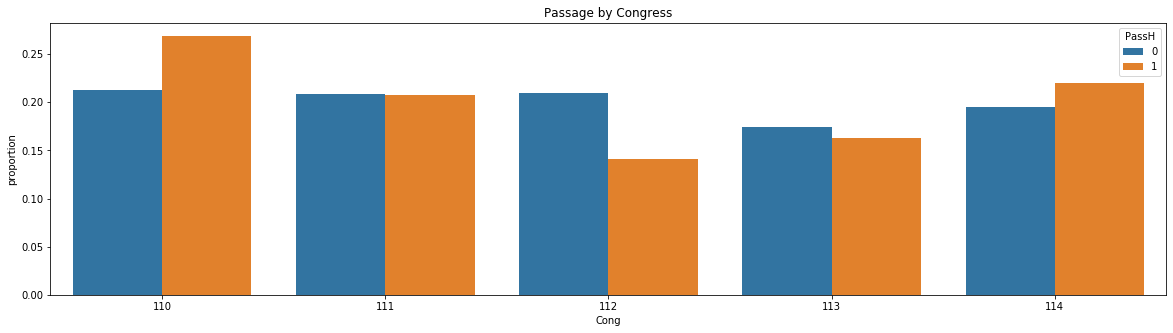

In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

def make_graph(df, X, Y, hue, title_):

    plt.figure(figsize=(20,5))

    x, y, hue = X, Y, hue
    hue_order = ["1", "0"]
    data=df

    fig = (df[x]
        .groupby(df[hue])
        .value_counts(normalize=True)
        .rename(y)
        .reset_index()
        .pipe((sns.barplot, "data"), x=x, y=y, hue=hue)
        .set_title(title_))
#     return st.plotly_chart(fig)
    return fig

make_graph(df, 'Cong', 'proportion', 'PassH', 'Passage by Congress')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102134 entries, 0 to 102133
Data columns (total 16 columns):
BillID            102134 non-null object
BillType          102134 non-null object
Chamber           102134 non-null int64
Cong              102134 non-null int64
Cosponsr          102134 non-null float64
Title             102134 non-null object
Mult              102134 non-null int64
District          102134 non-null float64
FrstConH          102134 non-null float64
Gender            102134 non-null int64
NameFull          102134 non-null object
Party             102134 non-null float64
Postal            102134 non-null object
PassH             102134 non-null int64
Majority          102134 non-null int64
dominant_topic    102134 non-null int64
dtypes: float64(4), int64(7), object(5)
memory usage: 12.5+ MB


In [7]:
df['NameFull'].value_counts().count()

936

In [8]:
#All bills passsed by the 112th Congress

pass_by_cong = bills_db.query("""
    SELECT
        cb.Cong,
        cb.PassH
    FROM con_bills.current_bills as cb
    WHERE cb.Cong = 112 
    AND cb.PassH = 1
    """)
pass_by_cong.head()

,Cong,PassH
0,112,1
1,112,1
2,112,1
3,112,1
4,112,1


In [9]:
#Total bills passed by Congress
#Lowest = 112th
#Highest = 110th

count_by_cong = bills_db.query("""
    SELECT
        count(*), cb.Cong
    FROM con_bills.current_bills as cb
    WHERE cb.PassH = 1
    AND cb.Cong >=110
    GROUP BY cb.Cong
    """)
count_by_cong.head()

,count(*),Cong
0,1082,110
1,836,111
2,567,112
3,654,113
4,886,114


In [10]:
#Way more bills in Topic 7 were introduced compared to other years
#Almost the same number of bills in topic 7 were passed as compared to other years

topic7_by_cong = bills_db.query("""
    SELECT
    count(*), cb.Cong
    FROM con_bills.current_bills as cb
    JOIN con_bills.topics as tp
    ON cb.BillID = tp.BillID
    WHERE tp.dominant_topic = 7
# AND cb.PassH = 1
    GROUP BY cb.Cong""")

topic7_by_cong

,count(*),Cong
0,2808,110
1,2668,111
2,4972,112
3,830,113
4,1058,114


In [11]:
#Total bills proposed by Congress

count_by_cong = bills_db.query("""
    SELECT
        count(*), cb.Cong
    FROM con_bills.current_bills as cb
    WHERE cb.Cong >=110
    GROUP BY cb.Cong
    """)
count_by_cong.head()

,count(*),Cong
0,11081,110
1,10629,111
2,10436,112
3,8866,113
4,10055,114


In [12]:
passed_bills = bills_db.query("""
    SELECT
        cb.BillID,
        cb.Cong,
        cb.NameFull,
        cb.Party,
        tp.dominant_topic
    FROM con_bills.current_bills as cb
    JOIN con_bills.topics as tp
    ON cb.BillID = tp.BillID
    WHERE cb.PassH = 1
    AND cb.Cong >=110
    """)
passed_bills.head()

,BillID,Cong,NameFull,Party,dominant_topic
0,110-HR-1,110,Bennie Thompson,100.0,5
1,110-HR-1,110,Bennie Thompson,100.0,5
2,110-HR-1003,110,Diane Watson,100.0,7
3,110-HR-1003,110,Diane Watson,100.0,7
4,110-HR-1006,110,Don Young,200.0,0


# **Final EDA - Topics and Metadata**

In [13]:
#import tokenizer

import spacy
from spacy.lang.en import English
import en_core_web_sm
import string
import re

nlp = English()

stop_words = spacy.lang.en.stop_words.STOP_WORDS

nlp.Defaults.stop_words |= {"bill","amend", "purpose", "united", "state", "states", "secretary", "act", "federal", "provide"}

replace_with_space = re.compile('[/(){}\[\]\|@,;]')

just_words = re.compile('[^a-zA-Z\s]')

# Create our list of punctuation marks
punctuations = string.punctuation

# Create our list of stopwords
nlp = spacy.load('en_core_web_sm')

stop_words = spacy.lang.en.stop_words.STOP_WORDS

In [14]:
def tokenizer(text):
    
    #lowercase everything
    lower_text = text.lower()
    
    #remove punctuation
#     no_pun_text = lower_text.translate(str.maketrans('', '', string.punctuation))
    
    #get rid of weird characters
    text = replace_with_space.sub('',lower_text)
    
    #remove numbers
    just_words_text = just_words.sub('', text)
    
    #add spacy tokenizer
    mytokens = nlp(just_words_text, disable=['parser', 'ner'])
#     print(mytokens)
    
    #for POS tagging
#     mytokens = [word for word in mytokens if (word.pos_ == 'NOUN') or (word.pos_ == 'VERB') or (word.pos_ == 'ADJ') or (word.pos_ == 'ADV')]
    
    #lemmatize
    mytokens = [word.lemma_.strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    
    #MAP SPECIFIC WORDS to others (veteran from veterans)

    #add stopwords
    mytokens = [word for word in mytokens if word not in stop_words and word not in punctuations]
    
    return mytokens
    

In [15]:
test = df['Title'].iloc[4]

tokenizer(test)
                        

['high',
 'education',
 'prevent',
 'veteran',
 'contribution',
 'education',
 'benefit',
 'reduce',
 'student',
 'financial',
 'assistance']

Text(0.5, 1.0, 'Proportion Bill Passage in House by Topic')

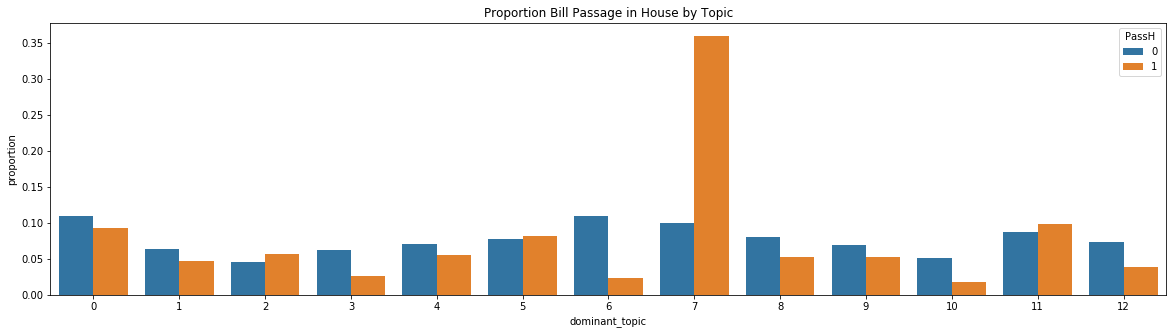

In [16]:
#Proportional Party breakdown by Congress
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

plt.figure(figsize=(20,5))

x, y, hue = "dominant_topic", "proportion", "PassH"
hue_order = ["1", "0"]
data=df

(df[x]
 .groupby(df[hue])
 .value_counts(normalize=True)
 .rename(y)
 .reset_index()
 .pipe((sns.barplot, "data"), x=x, y=y, hue=hue)
 .set_title('Proportion Bill Passage in House by Topic'))


# **Final Data Cleaning**

Add:
- Len title words or anything?
- tfidf on title?

REMOVE:
- PLawNum (not necessary for analysis)
- Major/Minor (no keys)
- PLawDate (too few)
- ImpBill (almost all are)


Edit: 
- BillType: 
- Chamber: To binary
- Cong: OHE
- Postal: OHE

How to deal with: Things that happen after House passage!?

In [19]:
df['NameFull'].value_counts()

Charles Schumer               954
Dianne Feinstein              904
Robert Casey                  894
David Vitter                  818
Robert Menendez               816
Sherrod Brown                 786
Ron Wyden                     634
Amy Klobuchar                 592
Barbara Boxer                 590
John Kerry                    574
Richard Durbin                570
Carolyn Maloney               534
Don Young                     524
Kirsten Gillibrand            500
Edward Markey                 484
Sheila Jackson Lee            466
Eleanor Norton                452
Lisa Murkowski                448
Orrin Hatch                   438
Mary Landrieu                 434
Jon Tester                    428
Alan Grayson                  428
Patrick Leahy                 426
Jeff Bingaman                 424
Carl Levin                    420
John Rockefeller              418
Steve Israel                  412
Patty Murray                  406
Benjamin Cardin               406
Charles Grassl

In [233]:
df.isnull().sum()

BillID            0
BillType          0
Chamber           0
Cong              0
Cosponsr          0
Title             0
Mult              0
District          0
FrstConH          0
Gender            0
NameFull          0
Party             0
Postal            0
PassH             0
Majority          0
dominant_topic    0
dtype: int64

In [234]:
#Replace Nulls in IntrDate - Figure out how to do this!
#Maybe change to just month or just year
# df['IntrDate'].head()

In [235]:
df.BillType.value_counts()

hr    33016
s     18051
Name: BillType, dtype: int64

# **Final Engineering:**

In [236]:
#One hot encode Postal - SHOULD I Assign to numerical?
df['Postal'].head()

0    MS
1    CA
2    CA
3    DC
4    SC
Name: Postal, dtype: object

In [367]:
#Do I want to try to encode the name?
df['NameFull'].value_counts().count()

test = df['NameFull']

#one hot encode only for the top bill people
#Consider adding only top, or thinking about the particular model that is running

def convert_names(x):
    if count(x) >= 400:
        return 1
    if 400 > count(x) >= 300:
        return 2
    
# convert_names(test)
        

NameError: name 'count' is not defined

**Engineer Cosponsors:**

Relevant info for cosponsorship: https://fas.org/sgp/crs/misc/RS22477.pdf

- min is 0, max is 432
- total value count is 325
- Big dropoff in count after around 30-40 cosponsors (becomes less than 100 instances)

In [238]:
test=[]
for x in df['Cosponsr']:
    if x == 38.0:
        test.append(x)
        
len(test)

123

In [239]:
def cosponsr_clean(x):
    if x <= 44.0:
        return x
    if x > 44.0:
        return 50
        

In [240]:
def party_clean(x):
    if x == 100.0:
        return 0
    if x == 200.0:
        return 1
    if x == 328.0:
        return 3

In [241]:
def billtype_clean(x):
    if x == 'hr':
        return 0
    if x == 's':
        return 1
     

In [242]:
df.Majority.value_counts()

1    31229
0    19838
Name: Majority, dtype: int64

**Add Columns:**

- Add a columns of Title Length. We saw in EDA that title length for passing bills tended to be longer.
- Add cleaned cosponsor column

In [243]:
def final_columns(df):
    
    df['title_len'] = [len(summary) for summary in df['Title']]
    
    df['BillType'] = df['BillType'].map(lambda x: billtype_clean(x))
    
    df['clean_cosponsr'] = df['Cosponsr'].map(lambda x: cosponsr_clean(x))

    df['clean_party'] = df['Party'].map(lambda x: party_clean(x))
    
    df.drop(columns=['Cosponsr', 'Party'], inplace=True)
        
    return df

# Finalize Dataframe:

In [244]:
final_df = final_columns(df)

In [245]:
final_df.head()

,BillID,BillType,Chamber,Cong,Title,Mult,District,FrstConH,Gender,NameFull,Postal,PassH,Majority,dominant_topic,title_len,clean_cosponsr,clean_party
0,110-HR-1,0,0,110,To provide for the implementation of the recom...,1,2.0,0.0,0,Bennie Thompson,MS,1,1,5,128,50.0,0
1,110-HR-10,0,0,110,Reserved for Speaker.,0,8.0,0.0,1,Nancy Pelosi,CA,0,1,10,21,0.0,0
2,110-HR-100,0,0,110,To amend the Higher Education Act of 1965 to p...,0,53.0,0.0,1,Susan Davis,CA,0,1,4,150,10.0,0
3,110-HR-1000,0,0,110,To award a congressional gold medal to Edward ...,0,0.0,0.0,1,Eleanor Norton,DC,0,1,10,136,50.0,0
4,110-HR-1001,0,0,110,To amend the Haitian Hemispheric Opportunity t...,0,5.0,0.0,0,John Spratt,SC,0,1,5,201,0.0,0


In [246]:
final_df.shape

(51067, 17)

# Undersampling

In [303]:
# example of random undersampling to balance the class distribution
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.under_sampling import RandomUnderSampler

# define undersample strategy
undersample = RandomUnderSampler(sampling_strategy='majority')

Using TensorFlow backend.


In [304]:

# fit and apply the transform
X_over, y_over = undersample.fit_resample(X, y)

In [305]:
print(Counter(y_over))

Counter({0: 4025, 1: 4025})


In [ ]:

# # define pipeline
# steps = [('under', RandomUnderSampler()), ('model', DecisionTreeClassifier())]
# pipeline = Pipeline(steps=steps)

# **Train and Test**

In [247]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=['PassH'], axis=1)
y = df['PassH']


In [248]:
X.head()


,BillID,BillType,Chamber,Cong,Title,Mult,District,FrstConH,Gender,NameFull,Postal,Majority,dominant_topic,title_len,clean_cosponsr,clean_party
0,110-HR-1,0,0,110,To provide for the implementation of the recom...,1,2.0,0.0,0,Bennie Thompson,MS,1,5,128,50.0,0
1,110-HR-10,0,0,110,Reserved for Speaker.,0,8.0,0.0,1,Nancy Pelosi,CA,1,10,21,0.0,0
2,110-HR-100,0,0,110,To amend the Higher Education Act of 1965 to p...,0,53.0,0.0,1,Susan Davis,CA,1,4,150,10.0,0
3,110-HR-1000,0,0,110,To award a congressional gold medal to Edward ...,0,0.0,0.0,1,Eleanor Norton,DC,1,10,136,50.0,0
4,110-HR-1001,0,0,110,To amend the Haitian Hemispheric Opportunity t...,0,5.0,0.0,0,John Spratt,SC,1,5,201,0.0,0


In [249]:
#Do i need to transform back after modeling?
# encoder = preprocessing.LabelEncoder()

# y_train = encoder.fit_transform(y_train1)
# y_test = encoder.fit_transform(y_test1)

**One hot encoding**

All categorical variables:
- 

In [250]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

Then One-Hot-Encode:

- Encode categorical integer features using a one-hot aka one-of-K scheme.
- The input to this transformer should be a matrix of integers, denoting the values taken on by categorical (discrete) features.
- The output will be a sparse matrix where each column corresponds to one possible value of one feature.
- It is assumed that input features take on values in the range [0, n_values).
- This encoding is needed for feeding categorical data to many scikit-learn estimators, notably linear models and SVMs with the standard kernels.

# **Modeling**

Import packages:

- CountVectorizer
- TFIDF

- Naive Bayes
- Logistic Regression
- Random Forest

**Remember to look at feature importances!

In [288]:
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction import FeatureHasher
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
# from tokenizer_schema import tokenizer

# We will train our classifier with the following features:

# We create the preprocessing pipelines for all data types.


In [252]:
no_change_features = ['PassH', 'Chamber','Mult', 'Gender', 'Majority']
# no_change_transformer = Pipeline(steps=[
#     ()])

In [289]:
word_features = ['Title']
word_transformer = Pipeline(steps=[
    ('tfidf', CountVectorizer(tokenizer=tokenizer))])

# for adding to preprocessor
# ('word', word_transformer, word_features),

In [290]:
numeric_features = ['clean_cosponsr', 'title_len']
numeric_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())])

In [291]:
categorical_features = ['Postal', 'dominant_topic', 'District', 'Cong', 'clean_party', 'FrstConH', 'NameFull']
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

In [308]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline - laid out for each model below.

In [309]:
preprocessor

ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
                  transformer_weights=None,
                  transformers=[('num',
                                 Pipeline(memory=None,
                                          steps=[('scaler',
                                                  MinMaxScaler(copy=True,
                                                               feature_range=(0,
                                                                              1)))],
                                          verbose=False),
                                 ['clean_cosponsr', 'title_len']),
                                ('cat',
                                 Pipeline(memory=None,
                                          steps=[('onehot',
                                                  OneHotEncoder(categories='auto',
                                                                drop=None,
                                                    

In [310]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler

# column_tuples = [
#     ('Chamber', None),
#     ('Mult', None),
#     ('Gender', None),
#     ('Majority', None),
#     ('Title', TfidfVectorizer(tokenizer=tokenizer))]

# column_tuples = [
#     ('Sales', None),
#     ('PassH', None),
#     ('Chamber', None),
#     ('Mult', None),
#     ('Gender', None),
#     ('Majority', None),
#     ('Title', TfidfVectorizer(tokenizer=tokenizer))
#     (['clean_cosponsr'], StandardScaler()),
#     ('title_len', MinMaxScaler()), 
#     ('Postal', OneHotEncoder(handle_unknown='ignore')),
#     ('dominant_topic', OneHotEncoder(handle_unknown='ignore')),
#     ('District', OneHotEncoder(handle_unknown='ignore')),
#     ('Cong', OneHotEncoder(handle_unknown='ignore')),
#     ('clean_party', OneHotEncoder(handle_unknown='ignore')),
#     ('FrstConH', OneHotEncoder(handle_unknown='ignore')),
#     ('NameFull',OneHotEncoder(handle_unknown='ignore'))]

mapper = DataFrameMapper(column_tuples, default=StandardScaler())

# mapper_fit = mapper.fit(X_train)

**Train test split**

In [311]:
#Train Test split!
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state=1)

In [312]:
X_train.shape

(40853, 16)

In [313]:
X_test.shape

(10214, 16)

In [314]:
y_train.shape

(40853,)

In [315]:
y_test.shape

(10214,)

Chi-square

In [365]:
# from sklearn.feature_selection import chi2
# from sklearn.feature_selection import SelectKBest

# cat_preprocessor = ColumnTransformer(
#     transformers=[
#         ('cat', categorical_transformer, categorical_features)
#     ])


# chi2_selector = Pipeline(steps=[('preprocessor', cat_preprocessor),
#                       ('feature_selection', SelectKBest(chi2, k=2))]) #get parameters

# #Get feature names and importances
# # c2_feature_names = chi2_selector.named_steps['preprocessor'].transformers_[1][1]\
# #    .named_steps['onehot'].get_feature_names(categorical_features)

# # c2_importances = rf_pipeline.steps[1][1].feature_importances_

# # Select two features with highest chi-squared statistics
# chi2_selector.fit(X, y)

# # Look at scores returned from the selector for each feature
# chi2_scores = pd.DataFrame(list(zip(X.feature_names, chi2_selector.scores_, chi2_selector.pvalues_)), columns=['ftr', 'score', 'pval'])
# chi2_scores

# # you can see that the kbest returned from SelectKBest 
# #+ were the two features with the _highest_ score
# kbest = np.asarray(X.feature_names)[chi2_selector.get_support()]
# kbest

**Base Classfier**

**Naive Bayes**

In [317]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


nb = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', MultinomialNB())]) #get parameters
parameters = None

nb.fit(X_train, y_train)

nb_y_pred = nb.predict(X_test)

print(confusion_matrix(y_test, nb_y_pred))
print(classification_report(y_test, nb_y_pred))

nb_confusion_matrix = (confusion_matrix(y_test, nb_y_pred))

[[9228  160]
 [ 694  132]]
              precision    recall  f1-score   support

           0       0.93      0.98      0.96      9388
           1       0.45      0.16      0.24       826

    accuracy                           0.92     10214
   macro avg       0.69      0.57      0.60     10214
weighted avg       0.89      0.92      0.90     10214



Text(0.5, 1, 'Confusion Matrix')

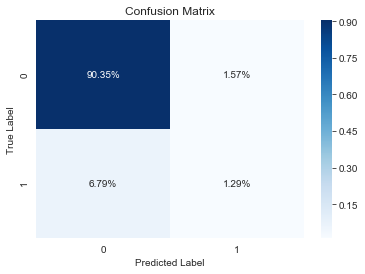

In [318]:
import seaborn as sns
import matplotlib.pyplot as plt

#shows percent data represented in each quadrant

sns.heatmap(nb_confusion_matrix/np.sum(nb_confusion_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')

Use Pipeline or DFMapper!

EXAMPLE

In [41]:

# data = data.fillna('')
 
# #Add the features of the dataframe that you want to transform and/or combine
# mapper = DataFrameMapper([
#      ('Summary', TfidfVectorizer()), #add paramaters from Topic Modeling
#      ('nb_like', None),
#      ('picture_labels', TfidfVectorizer()),
#      ('nb_share', None),
#  ])
 
# """
# Use the fit_transform method to transform the old dataframe into a new one
# that can be fed to the machine learning algorithm.
# """
 
# #sample Usage
# features = mapper.fit_transform(data)
# categories = data['INDEX New']
 
# # Split the data between train and test
# x, x_test, y, y_test = train_test_split(features,categories,test_size=0.2,train_size=0.8, random_state = 0)
 
# clf = sk.RandomForestClassifier(random_state=0)
# clf.fit(x, y)
 
# predicted = clf.predict(x_test)
 
# printreport(y_test, predicted)

# **Logistic Regression**

- Precision means the percentage of your results which are relevant. 
- recall refers to the percentage of total relevant results correctly classified by your algorithm.

Also make a precision recall curve

In [351]:
from sklearn.linear_model import LogisticRegression

# Bring in OHE?

lr_clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression(class_weight='balanced', C=.8, penalty='l2', n_jobs=-1))]) #get parameters

# Logistic Regression Classifier
# lr_classifier = LogisticRegression()

lr_clf.fit(X_train, y_train)

lr_y_pred = lr_clf.predict(X_test)

print(confusion_matrix(y_test, lr_y_pred))
print(classification_report(y_test, lr_y_pred))

lr_confusion_matrix = confusion_matrix(y_test, lr_y_pred)

[[7205 2183]
 [ 233  593]]
              precision    recall  f1-score   support

           0       0.97      0.77      0.86      9388
           1       0.21      0.72      0.33       826

    accuracy                           0.76     10214
   macro avg       0.59      0.74      0.59     10214
weighted avg       0.91      0.76      0.81     10214



In [359]:
# Probability estimates.
lr_clf.predict_proba(X_test)

array([[0.87957466, 0.12042534],
       [0.9464496 , 0.0535504 ],
       [0.84485305, 0.15514695],
       ...,
       [0.83451857, 0.16548143],
       [0.65426547, 0.34573453],
       [0.94796175, 0.05203825]])

In [355]:
# Return the mean accuracy on the given test data and labels.
lr_clf.score(X_test, y_test)

0.7634619150186019

Text(0.5, 1, 'Confusion Matrix')

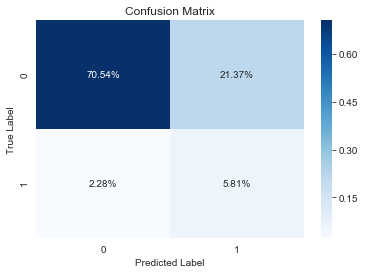

In [335]:
import seaborn as sns
import matplotlib.pyplot as plt

#shows percent data represented in each quadrant

sns.heatmap(lr_confusion_matrix/np.sum(lr_confusion_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')

**Testing the predications:**

In [340]:
lr_y_pred[101]

1

In [341]:
y_test.iloc[101]

0

In [342]:
X_test.reset_index()

,index,BillID,BillType,Chamber,Cong,Title,Mult,District,FrstConH,Gender,NameFull,Postal,Majority,dominant_topic,title_len,clean_cosponsr,clean_party
0,11864,111-HR-1703,0,0,111,To require a study and comprehensive analytica...,0,2.0,0.0,0,Chaka Fattah,PA,1,1,257,0.0,0
1,50195,114-S-3407,1,1,114,A bill to amend the Public Health Service Act ...,0,0.0,0.0,0,Mark Kirk,IL,1,12,231,3.0,1
2,8384,110-S-1939,1,1,110,A bill to provide for the conveyance of certai...,0,0.0,0.0,0,Jeff Bingaman,NM,1,11,97,1.0,0
3,14800,111-HR-4346,0,0,111,To establish a commission to commemorate the e...,0,14.0,0.0,0,John Conyers,MI,1,5,116,4.0,0
4,24437,112-HR-3458,0,0,112,To amend title XVIII of the Social Security Ac...,1,18.0,0.0,0,Aaron Schock,IL,1,3,215,25.0,1
5,24034,112-HR-3095,0,0,112,To freeze the implementation of the health ref...,1,3.0,0.0,0,Sam Johnson,TX,1,12,298,3.0,1
6,17726,111-S-1066,1,1,111,A bill to amend title XVIII of the Social Secu...,0,0.0,0.0,0,Charles Schumer,NY,1,3,123,24.0,0
7,13874,111-HR-3512,0,0,111,"To amend title 18, United States Code, to prev...",0,1.0,0.0,0,Steve Scalise,LA,0,0,145,1.0,1
8,44760,114-HR-4392,0,0,114,"To amend title 5, United States Code, to requi...",0,15.0,0.0,0,Dennis Ross,FL,1,4,183,1.0,1
9,42303,114-HR-2173,0,0,114,To require States to conduct Congressional red...,0,19.0,0.0,1,Zoe Lofgren,CA,0,5,113,50.0,0


In [343]:
X_test.iloc[101]

BillID                                                   110-S-3551
BillType                                                          1
Chamber                                                           1
Cong                                                            110
Title             An original bill to amend the Public Works and...
Mult                                                              0
District                                                          0
FrstConH                                                          0
Gender                                                            1
NameFull                                              Barbara Boxer
Postal                                                           CA
Majority                                                          1
dominant_topic                                                    7
title_len                                                       128
clean_cosponsr                                  

In [344]:
X_test

,BillID,BillType,Chamber,Cong,Title,Mult,District,FrstConH,Gender,NameFull,Postal,Majority,dominant_topic,title_len,clean_cosponsr,clean_party
11864,111-HR-1703,0,0,111,To require a study and comprehensive analytica...,0,2.0,0.0,0,Chaka Fattah,PA,1,1,257,0.0,0
50195,114-S-3407,1,1,114,A bill to amend the Public Health Service Act ...,0,0.0,0.0,0,Mark Kirk,IL,1,12,231,3.0,1
8384,110-S-1939,1,1,110,A bill to provide for the conveyance of certai...,0,0.0,0.0,0,Jeff Bingaman,NM,1,11,97,1.0,0
14800,111-HR-4346,0,0,111,To establish a commission to commemorate the e...,0,14.0,0.0,0,John Conyers,MI,1,5,116,4.0,0
24437,112-HR-3458,0,0,112,To amend title XVIII of the Social Security Ac...,1,18.0,0.0,0,Aaron Schock,IL,1,3,215,25.0,1
24034,112-HR-3095,0,0,112,To freeze the implementation of the health ref...,1,3.0,0.0,0,Sam Johnson,TX,1,12,298,3.0,1
17726,111-S-1066,1,1,111,A bill to amend title XVIII of the Social Secu...,0,0.0,0.0,0,Charles Schumer,NY,1,3,123,24.0,0
13874,111-HR-3512,0,0,111,"To amend title 18, United States Code, to prev...",0,1.0,0.0,0,Steve Scalise,LA,0,0,145,1.0,1
44760,114-HR-4392,0,0,114,"To amend title 5, United States Code, to requi...",0,15.0,0.0,0,Dennis Ross,FL,1,4,183,1.0,1
42303,114-HR-2173,0,0,114,To require States to conduct Congressional red...,0,19.0,0.0,1,Zoe Lofgren,CA,0,5,113,50.0,0


**ROC/AUC Curve**

In [345]:
#for ROC/AUC Curve

lr_dec = lr_clf.decision_function(X_test)

In [346]:
import numpy as np
from sklearn.metrics import roc_auc_score
lr_roc_auc = roc_auc_score(y_test, lr_y_pred)
lr_roc_auc

#This is a decent ROC Score. Remember lays between .5 and 1

0.7426933925231428

For ROC/AUC - Edit the threshold, which starts at 0.

Test AUC: 0.8314779776562939


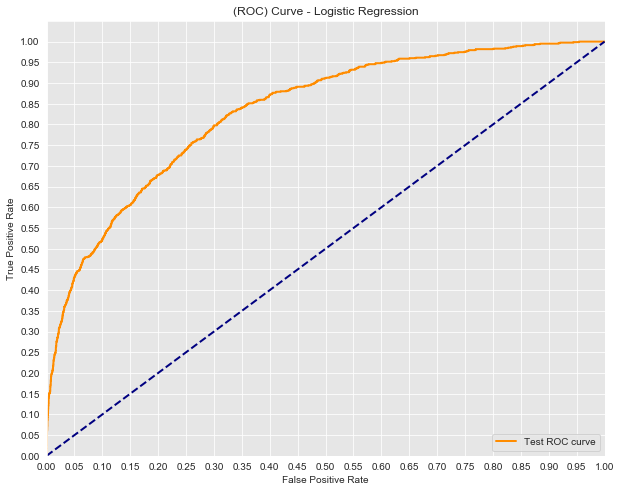

In [347]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

test_fpr, test_tpr, test_thresholds = roc_curve(y_test, lr_dec)

print('Test AUC: {}'.format(auc(test_fpr, test_tpr)))

# Seaborn's beautiful styling
sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

plt.figure(figsize=(10, 8))
lw = 2

plt.plot(test_fpr, test_tpr, color='darkorange',
         lw=lw, label='Test ROC curve')

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('(ROC) Curve - Logistic Regression')
plt.legend(loc='lower right')
plt.show()

In [348]:
from sklearn.metrics import average_precision_score

lr_average_precision = average_precision_score(y_test, lr_dec)

print('Average precision-recall score: {0:0.2f}'.format(
      lr_average_precision))

Average precision-recall score: 0.41


Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.41')

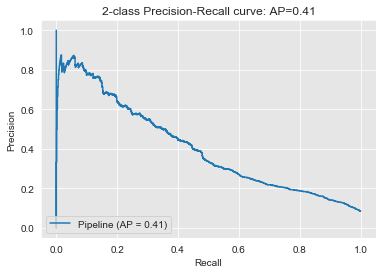

In [349]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
import matplotlib.pyplot as plt

disp = plot_precision_recall_curve(lr_clf, X_test, y_test)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(lr_average_precision))

# **SVM Classifier:**

In [ ]:
from sklearn.svm import SVC

svm = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', SVC(class_weight = 'balanced', C=1e5, kernel='linear'))])


svm.fit(X_train, y_train)

svm_y_pred = svm.predict(X_test)

print(confusion_matrix(y_test, svm_y_pred))
print(classification_report(y_test, svm_y_pred))

svm_confusion_matrix = confusion_matrix(y_test, svm_y_pred)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

#shows percent data represented in each quadrant

sns.heatmap(svm_confusion_matrix/np.sum(svm_confusion_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')

In [ ]:
import numpy as np
from sklearn.metrics import roc_auc_score
svm_roc_auc = roc_auc_score(y_test, svm_y_pred)
svm_roc_auc

#This is an okish AUC Score

In [ ]:
svm_dec = svm.decision_function(X_test)

In [ ]:
#AUC/ROC Curve

test_fpr, test_tpr, test_thresholds = roc_curve(y_test, svm_dec)

print('Test AUC: {}'.format(auc(test_fpr, test_tpr)))

sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

plt.figure(figsize=(10, 8))
lw = 2

plt.plot(test_fpr, test_tpr, color='darkorange',
         lw=lw, label='Test ROC curve')

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('(ROC) Curve - SVM Classifier')
plt.legend(loc='lower right')
plt.show()

In [ ]:
from sklearn.metrics import average_precision_score

svm_average_precision = average_precision_score(y_test, svm_dec)

print('Average precision-recall score: {0:0.2f}'.format(
      lr_average_precision))

In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
import matplotlib.pyplot as plt

disp = plot_precision_recall_curve(svm, X_test, y_test)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(svm_average_precision))

# **SGD Classifer**

In [378]:
from sklearn.linear_model import SGDClassifier

sgd = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', SGDClassifier(loss='log'))])


sgd.fit(X_train, y_train)

sgd_y_pred = sgd.predict(X_test)

print(confusion_matrix(y_test, sgd_y_pred))
print(classification_report(y_test, sgd_y_pred))

sg_confusion_matrix = confusion_matrix(y_test, sgd_y_pred)

[[9346   42]
 [ 690  136]]
              precision    recall  f1-score   support

           0       0.93      1.00      0.96      9388
           1       0.76      0.16      0.27       826

    accuracy                           0.93     10214
   macro avg       0.85      0.58      0.62     10214
weighted avg       0.92      0.93      0.91     10214



Text(0.5, 1, 'Confusion Matrix')

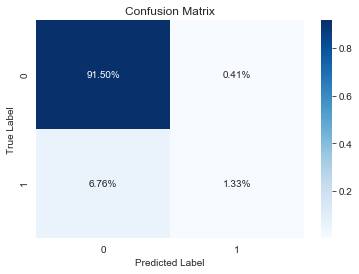

In [379]:
import seaborn as sns
import matplotlib.pyplot as plt

#shows percent data represented in each quadrant

sns.heatmap(sg_confusion_matrix/np.sum(sg_confusion_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')

In [64]:
sgd_dec = sgd.decision_function(X_test)

In [63]:
import numpy as np
from sklearn.metrics import roc_auc_score
sgd_roc_auc = roc_auc_score(y_test, sgd_y_pred)
sgd_roc_auc

#This is a terrible AUC score!

0.5

Test AUC: 0.8109557974685111


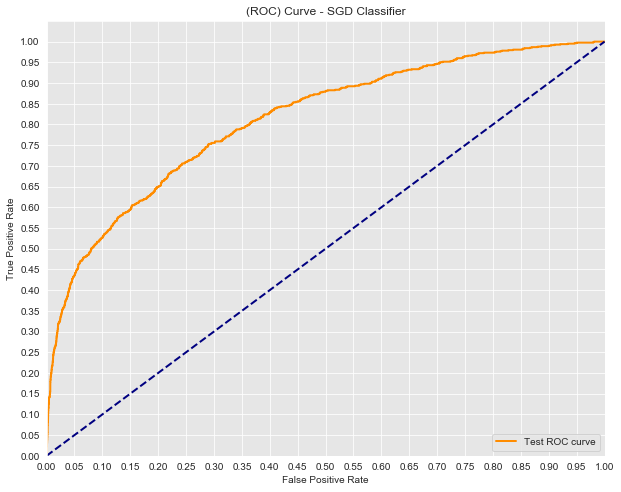

In [66]:
#AUC/ROC Curve

test_fpr, test_tpr, test_thresholds = roc_curve(y_test, sgd_dec)

print('Test AUC: {}'.format(auc(test_fpr, test_tpr)))

sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

plt.figure(figsize=(10, 8))
lw = 2

plt.plot(test_fpr, test_tpr, color='darkorange',
         lw=lw, label='Test ROC curve')

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('(ROC) Curve - SGD Classifier')
plt.legend(loc='lower right')
plt.show()

# **Random Forest**

Class Imbalance: To overcome this issue, we used repeated random sub-sampling. Initially, we construct the testing data and the NoS training data sub-samples. For each disease, we train NoS classifiers and test all of them on the same data set. The final labels of the testing data are computed using a majority voting scheme.

In [99]:
from sklearn.ensemble import RandomForestClassifier

#add bag of trees?
#add OHE

rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RandomForestClassifier(max_depth=None, max_features='auto', n_estimators=10, class_weight="balanced"))])


rf_pipeline.fit(X_train, y_train) 

rf_y_pred = rf_pipeline.predict(X_test)

print(confusion_matrix(y_test, rf_y_pred))
print(classification_report(y_test, rf_y_pred))

rf_confusion_matrix = confusion_matrix(y_test, rf_y_pred)

[[9273  115]
 [ 602  224]]
              precision    recall  f1-score   support

           0       0.94      0.99      0.96      9388
           1       0.66      0.27      0.38       826

    accuracy                           0.93     10214
   macro avg       0.80      0.63      0.67     10214
weighted avg       0.92      0.93      0.92     10214



Text(0.5, 1, 'Confusion Matrix')

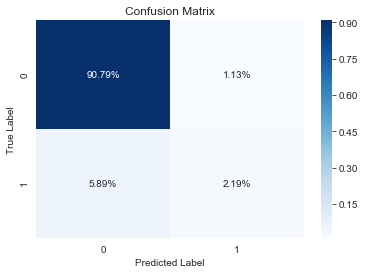

In [100]:
import seaborn as sns
import matplotlib.pyplot as plt

#shows percent data represented in each quadrant

sns.heatmap(rf_confusion_matrix/np.sum(rf_confusion_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')

In [107]:
feature_names = rf_pipeline.named_steps['preprocessor'].transformers_[1][1]\
   .named_steps['onehot'].get_feature_names(categorical_features)

In [108]:
importances = rf_pipeline.steps[1][1].feature_importances_
len(importances)

1078

In [109]:
indices = np.argsort(importances)[::-1]
top_k = 10
new_indices = indices[:top_k]

In [110]:
new_indices

array([  1,   0,  65,  71,  64, 126, 125, 127, 128,  58])

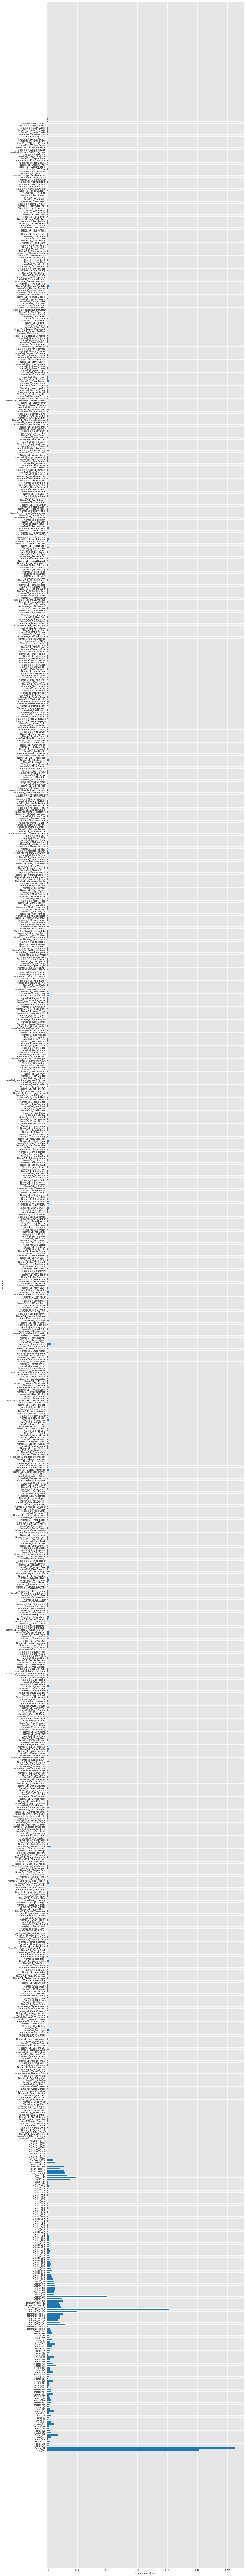

In [111]:
import matplotlib.pyplot as plt

def plot_feature_importances(model):
    
#     n_features = importances.shape
    
    plt.figure(figsize=(15,200))
    plt.barh(range(1078), importances, align='center') 
    
    plt.yticks(np.arange(1078), feature_names) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')

plot_feature_importances(rf_pipeline)

In [113]:
import numpy as np
from sklearn.metrics import roc_auc_score
rf_roc_auc = roc_auc_score(y_test, rf_y_pred)
rf_roc_auc

#This is a medium AUC score!

0.6294683801174236

**FINAL MODEL**

**Further Evaluation**:
- Classification Report
- Confusion Matrix
- ROC/AUC

https://www.kaggle.com/selener/multi-class-text-classification-tfidf

# Comparing all Models:

In [ ]:
models = [
    RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]

# 5 Cross-validation
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))

entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
    
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

In [ ]:

mean_accuracy = cv_df.groupby('model_name').accuracy.mean()
std_accuracy = cv_df.groupby('model_name').accuracy.std()

acc = pd.concat([mean_accuracy, std_accuracy], axis= 1, 
          ignore_index=True)
acc.columns = ['Mean Accuracy', 'Standard deviation']
acc